In [1]:
import sys
import os

# Add the project root to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from src.helpers import *
from src.implementations import *
from src.preprocessing import *
from src.crossvalidation import *
from src.model_evaluation import *

# Loading Data and Preprocessing

In [ ]:
# Selecting the appropriate data folder
#data_folder = './data/'
data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
#data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/MilaLyon/data/"
#data_folder = "C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/MilaLyon/data/"

In [ ]:
# Load the data
csv_data = load_csv_data(data_folder, max_rows=None, dictionnary=True)

In [ ]:
# Preprocess the data
data_copy = dict(csv_data)
preprocess_data(data_copy, nan_drop_threshold=0.9, correlation_threshold=0.01, n_std=3, only_health_related=False, split_val=True, val_size=0.1)

x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)
zero_values: <class 'numpy.ndarray'> with shape (321,)
default_values: <class 'numpy.ndarray'> with shape (321,)
ordinal: <class 'numpy.ndarray'> with shape (321,)
continuous: <class 'numpy.ndarray'> with shape (321,)
99 features with too many missing values dropped.
One-hot encoding completed. Number of features increased from

c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ACER\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


213 features with low correlation to target dropped.
41 features with high correlation dropped.
Clipped 1674725 values in x_train (2.00% of all entries)
Clipped 557995 values in x_test (2.00%)


In [5]:
print_shapes(data_copy)

x_train: <class 'numpy.ndarray'> with shape (295322, 255)
x_test: <class 'numpy.ndarray'> with shape (109379, 255)
y_train: <class 'numpy.ndarray'> with shape (295322,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (255,)
useless: <class 'numpy.ndarray'> with shape (255,)
health_related: <class 'numpy.ndarray'> with shape (255,)
better_elsewhere: <class 'numpy.ndarray'> with shape (255,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (255,)
binary: <class 'numpy.ndarray'> with shape (255,)
one_hot: <class 'numpy.ndarray'> with shape (255,)
zero_values: <class 'numpy.ndarray'> with shape (255,)
default_values: <class 'numpy.ndarray'> with shape (662,)
ordinal: <class 'numpy.ndarray'> with shape (255,)
continuous: <class 'numpy.ndarray'> with shape (255,)
x_val: <class 'numpy.ndarray'> with shape (32813, 255)
y_val: <class 'numpy.ndarray'> with shape (32813,)


The final preprocessed dataset contained 255 features. As expected for health-related data, the analysis of the training labels ($y_{train}$) revealed a class imbalance, with approximately a 10:1 ratio between the majority and minority classes.

Ratio of majority class to minority class: 10.35


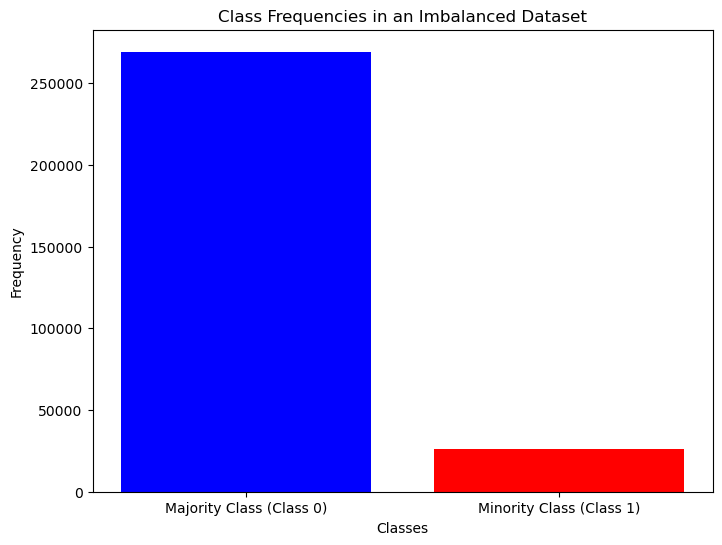

In [ ]:

# Count the frequencies of each class
class_counts = [len(data_copy['y_train'][data_copy['y_train'] == 0]), len(data_copy['y_train'][data_copy['y_train'] == 1])]

print(f"Ratio of majority class to minority class: {class_counts[0] / class_counts[1]:.2f}")

# Plot the class frequencies using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Majority Class (Class 0)', 'Minority Class (Class 1)'], class_counts, color=['blue', 'red'])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Frequencies in an Imbalanced Dataset')
plt.show()

# Model Selection and Hyperparameters tuning

## Learning Rate Selection in Logistic Regression

Crossvalidation to find best learning rate

In [26]:
max_iter = 1000

In [ ]:
# Using the generic cross-validation function
def learning_function(y, tx, gamma):
    initial_w = np.zeros(tx.shape[1])
    return logistic_regression(y, tx, initial_w, max_iters=max_iter, gamma=gamma)

gammas = [0.1, 0.2, 0.4, 0.6, 0.8]

best_gamma, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, gammas)

Param=0.1 | Mean F1=0.4153
Param=0.2 | Mean F1=0.4204
Param=0.4 | Mean F1=0.4239
Param=0.6 | Mean F1=0.4255
Param=0.8 | Mean F1=0.4267

✅ Best param: 0.8 (F1=0.4267)


Cross-validation indicated that $\gamma = 0.8$ yielded the highest F1 score. However, based on the training loss behavior, we selected $\gamma = 0.5$ as the maximum learning rate that avoids oscillations, ensuring stable convergence.

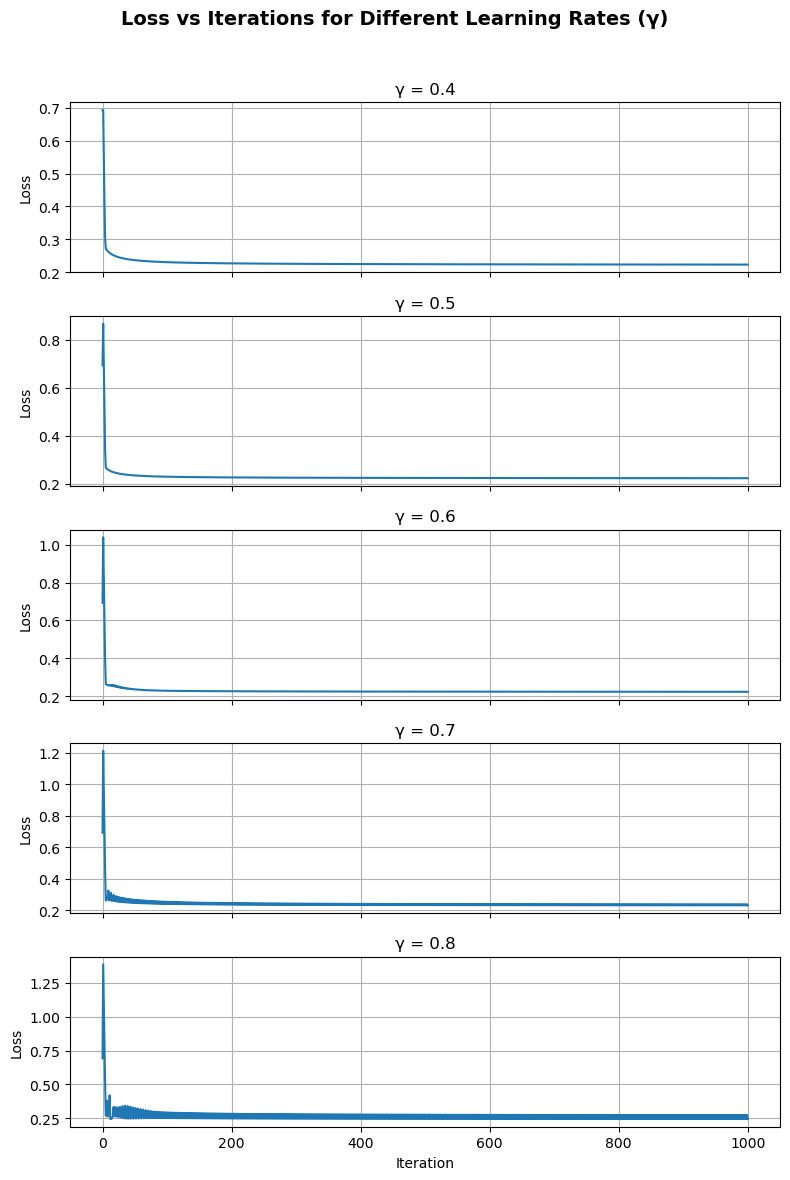

In [35]:
best_gamma = 0.8

✅ Best threshold: 0.21 | F1_val = 0.423 | Acc_val = 0.878


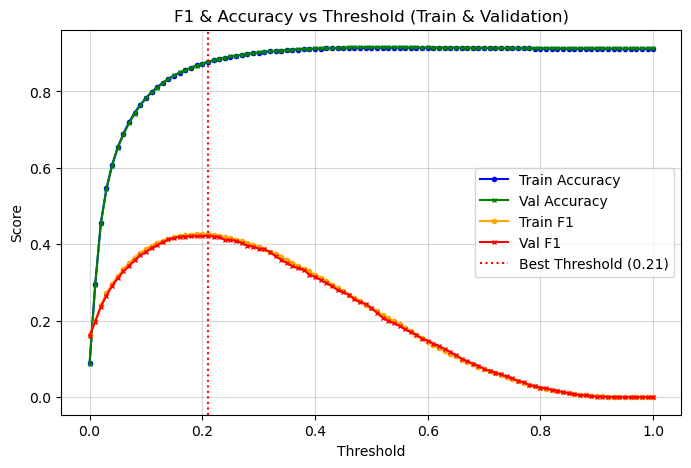

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\1762433807.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


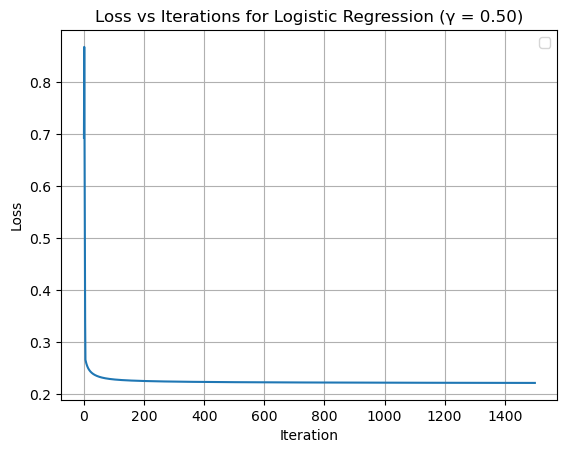

In [ ]:
# Train final model with best gamma and get training history
weights, losses = logistic_regression(data_copy['y_train'], data_copy['x_train'], np.zeros(data_copy['x_train'].shape[1]), max_iters=max_iter, gamma=best_gamma, return_history=True)
# Plot training and validation performance
best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights, losses)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression (γ = {best_gamma:.2f})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.37 | F1_val = 0.423 | Acc_val = 0.877


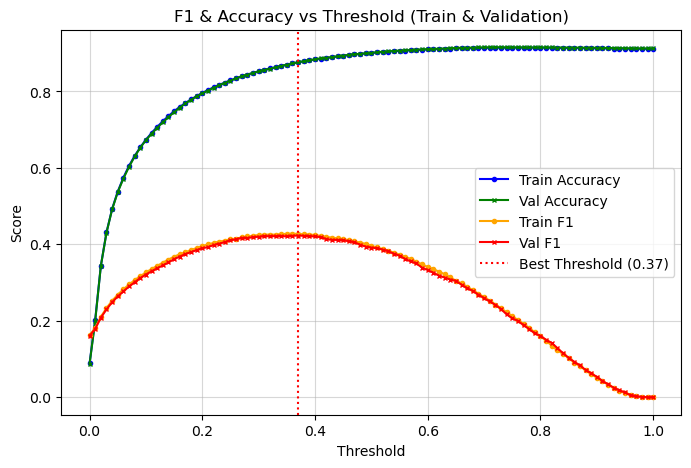

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\4041263099.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


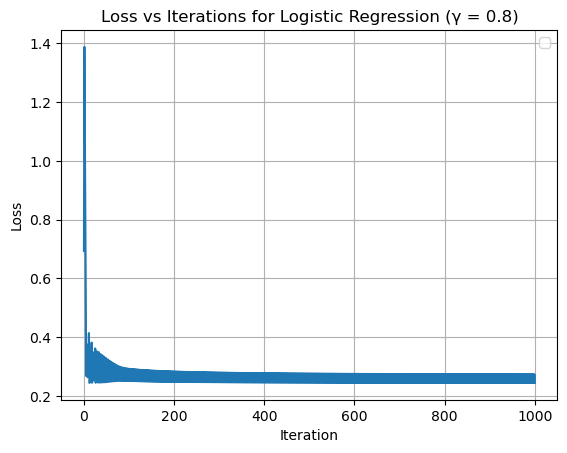

In [36]:
# Train final model with best gamma and get training history
weights, losses = logistic_regression(data_copy['y_train'], data_copy['x_train'], np.zeros(data_copy['x_train'].shape[1]), max_iters=max_iter, gamma=0.8, return_history=True)
# Plot training and validation performance
best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights, losses)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression (γ = 0.8)")
plt.legend()
plt.grid(True)
plt.show()

Although $\gamma = 0.8$ causes mild oscillations in the training loss, cross-validation showed that it consistently produced higher F1 scores than lower, smoother learning rates. Therefore, $\gamma = 0.8$ was chosen to prioritize validation performance while maintaining overall training stability.

## Lambda tuning in ridge logistic regression

In [ ]:
# Using the generic cross-validation function
def learning_function(y, tx, lambda_):
    initial_w = np.zeros(tx.shape[1])
    return reg_logistic_regression(y, tx, lambda_, initial_w, max_iters=max_iter, gamma=best_gamma)

lambdas = [1e-6, 1e-4, 1e-2, 1e-1]

best_lambda, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, lambdas)

Param=1e-06 | Mean F1=0.4267
Param=0.0001 | Mean F1=0.4263
Param=0.01 | Mean F1=0.4046
Param=0.1 | Mean F1=0.3093

✅ Best param: 1e-06 (F1=0.4267)


In [37]:
best_lambda = 1e-6

✅ Best threshold: 0.37 | F1_val = 0.423 | Acc_val = 0.877


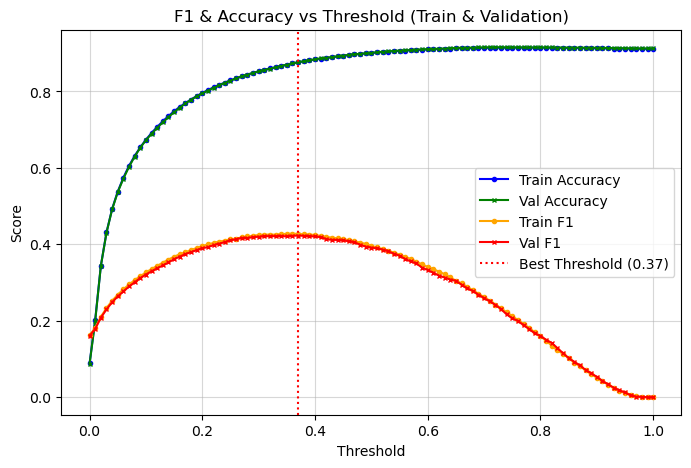

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\3895352881.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


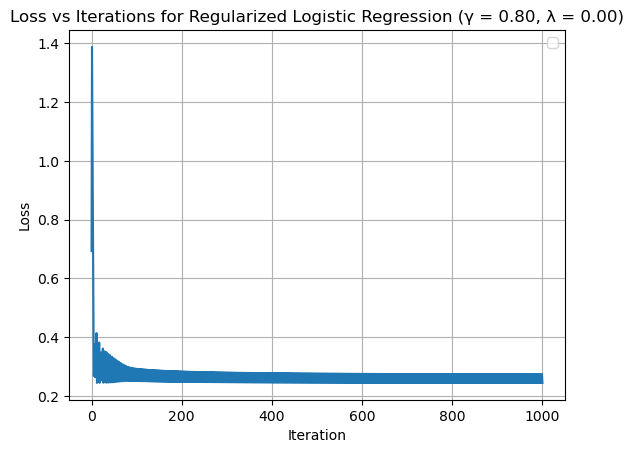

In [38]:
# Train final model with best gamma and get training history
weights_1, losses_1 = reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], best_lambda, np.zeros(data_copy['x_train'].shape[1]), max_iters=max_iter, gamma=best_gamma, return_history=True)
# Plot training and validation performance
best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights_1, losses_1)

plt.plot(losses_1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Regularized Logistic Regression (γ = {best_gamma:.2f}, λ = {best_lambda:.2f})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.37 | F1_val = 0.423 | Acc_val = 0.877


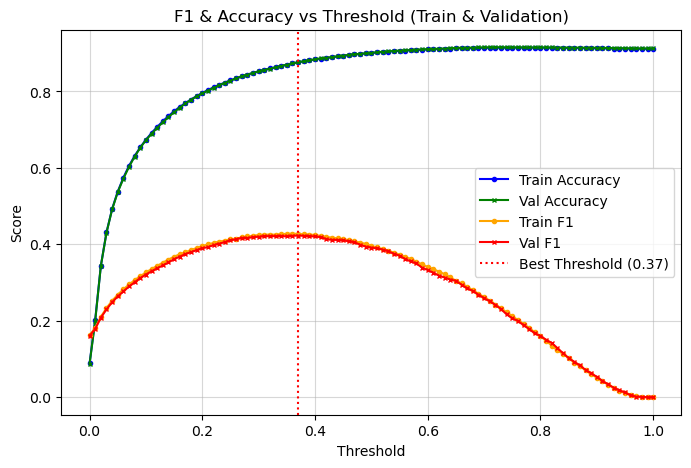

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\1495639487.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


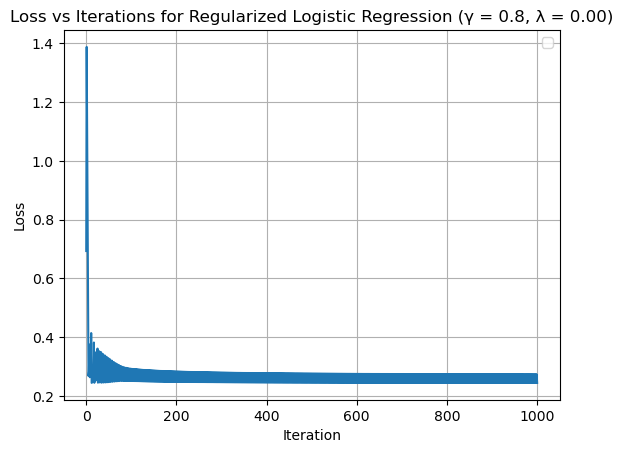

In [39]:
# Train final model with best gamma and get training history
weights_1, losses_1 = reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], best_lambda, np.zeros(data_copy['x_train'].shape[1]), max_iters=max_iter, gamma=0.8, return_history=True)
# Plot training and validation performance
best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights_1, losses_1)

plt.plot(losses_1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Regularized Logistic Regression (γ = 0.8, λ = {best_lambda:.2f})")
plt.legend()
plt.grid(True)
plt.show()

## Polynomial Feature Expansion

In [ ]:
degrees = [2,3,4]
best_degree, results = cross_validate_degrees(data_copy['x_train'], data_copy['y_train'], degrees, data_copy['continuous'], k=5, max_iters=max_iter, gamma=best_gamma)

Degree=2 | Mean F1=0.4253
Degree=3 | Mean F1=0.4247
Degree=4 | Mean F1=0.4247

✅ Best degree: 2 (F1=0.4253)


In [29]:
best_degree = 2

✅ Best threshold: 0.04 | F1_val = 0.424 | Acc_val = 0.863


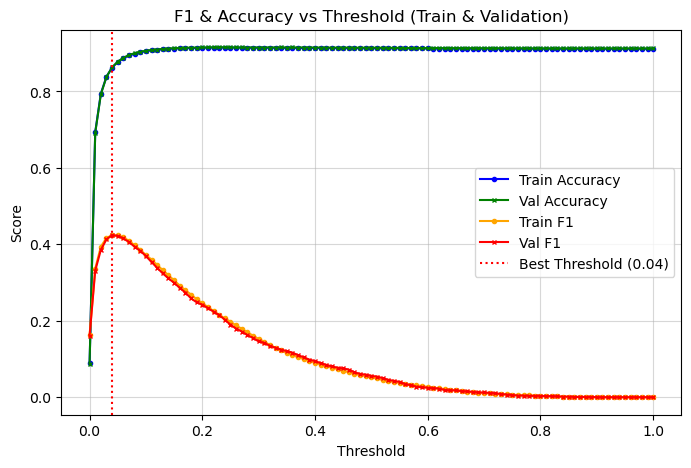

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\2609992879.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


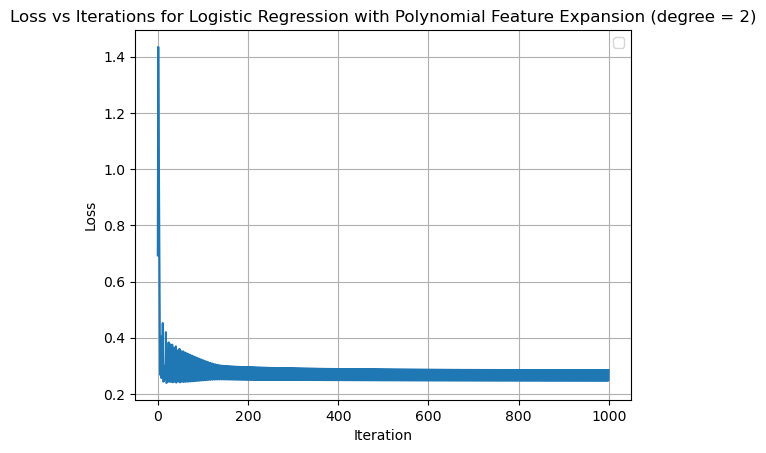

In [30]:
x_train_poly = build_poly(data_copy['x_train'], best_degree, to_expand=data_copy['continuous'])
x_val_poly = build_poly(data_copy['x_val'], best_degree, to_expand=data_copy['continuous'])
x_test_poly = build_poly(data_copy['x_test'], best_degree, to_expand=data_copy['continuous'])

weights_2, losses_2 = logistic_regression(data_copy['y_train'], x_train_poly, np.zeros(x_train_poly.shape[1]), max_iters=max_iter, gamma=0.8, return_history=True)

best_t = plot_training_validation_performance(x_train_poly, data_copy['y_train'], x_val_poly, data_copy['y_val'], weights_2, losses_2)

plt.plot(losses_2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression with Polynomial Feature Expansion (degree = {best_degree})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.21 | F1_val = 0.423 | Acc_val = 0.878


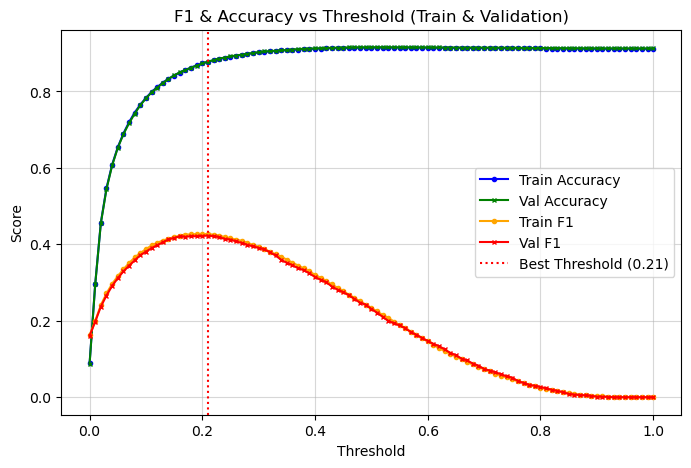

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\2681667367.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


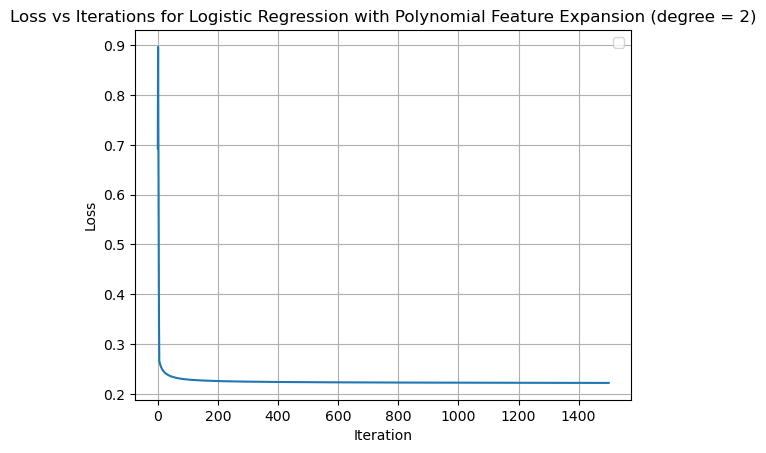

In [ ]:
x_train_poly = build_poly(data_copy['x_train'], best_degree, to_expand=data_copy['continuous'])
x_val_poly = build_poly(data_copy['x_val'], best_degree, to_expand=data_copy['continuous'])
x_test_poly = build_poly(data_copy['x_test'], best_degree, to_expand=data_copy['continuous'])

weights_2, losses_2 = logistic_regression(data_copy['y_train'], x_train_poly, np.zeros(x_train_poly.shape[1]), max_iters=max_iter, gamma=best_gamma, return_history=True)

best_t = plot_training_validation_performance(x_train_poly, data_copy['y_train'], x_val_poly, data_copy['y_val'], weights_2, losses_2)

plt.plot(losses_2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression with Polynomial Feature Expansion (degree = {best_degree})")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#best_t = 0.17
# Predict on test set and create submission file
test_pred = predict_labels_logistic(x_test_poly, weights_2[-1], threshold=best_t)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')

## Weighted logistic regression

In [ ]:
# Using the generic cross-validation function
def learning_function(y, tx, relative_weight):
    initial_w = np.zeros(tx.shape[1])
    sample_weights = 1 + (relative_weight - 1) * y
    return weighted_reg_logistic_regression(y, tx, 0, sample_weights, initial_w, max_iters=max_iter, gamma=best_gamma)

relative_weights = [1, 4, 6, 10, 14]
best_relative_weight, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, relative_weights)

Param=1 | Mean F1=0.4267
Param=4 | Mean F1=0.4203
Param=6 | Mean F1=0.4152
Param=10 | Mean F1=0.3579
Param=14 | Mean F1=0.4227

✅ Best param: 1 (F1=0.4267)


In [31]:
best_relative_weight = 1

✅ Best threshold: 0.37 | F1_val = 0.423 | Acc_val = 0.877


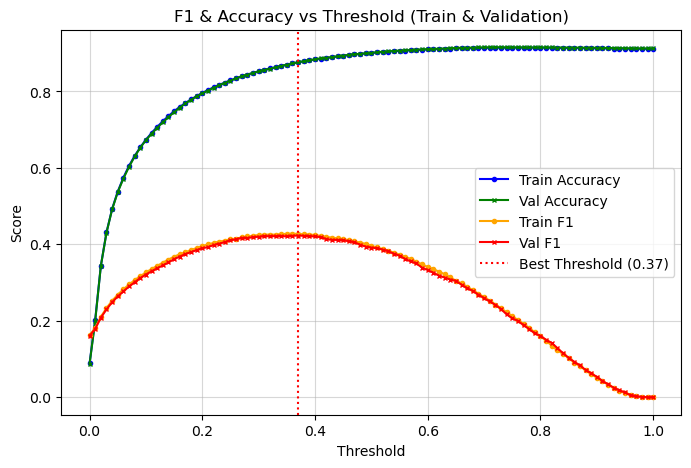

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\2776759365.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


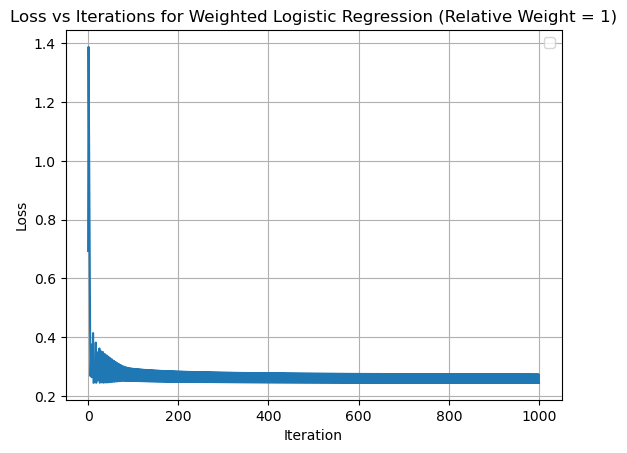

In [32]:
sample_weights = 1 + (best_relative_weight - 1) * data_copy['y_train']
initial_w = np.zeros(data_copy['x_train'].shape[1])
weights_3, losses_3 = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], 0, sample_weights, initial_w, max_iter, 0.8, return_history=True)

best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights_3, losses_3)

plt.plot(losses_3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Weighted Logistic Regression (Relative Weight = {best_relative_weight})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.21 | F1_val = 0.423 | Acc_val = 0.878


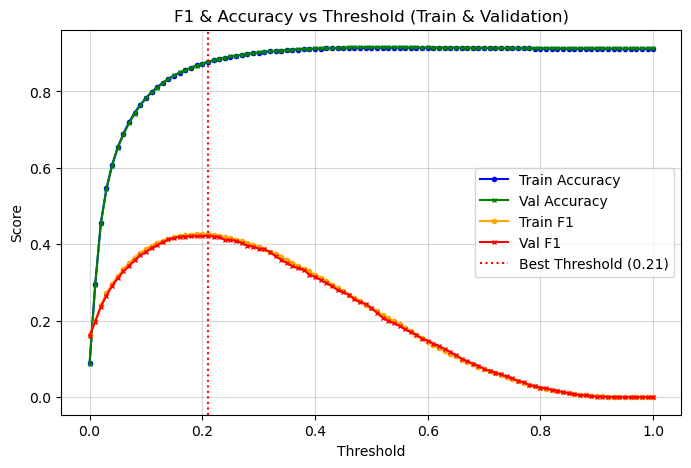

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\3531760162.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


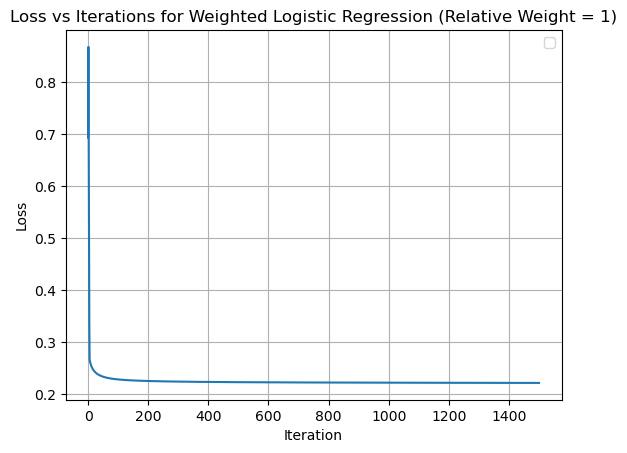

In [ ]:
sample_weights = 1 + (best_relative_weight - 1) * data_copy['y_train']
initial_w = np.zeros(data_copy['x_train'].shape[1])
weights_3, losses_3 = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], 0, sample_weights, initial_w, max_iter, best_gamma, return_history=True)

best_t = plot_training_validation_performance(data_copy['x_train'], data_copy['y_train'], data_copy['x_val'], data_copy['y_val'], weights_3, losses_3)

plt.plot(losses_3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Weighted Logistic Regression (Relative Weight = {best_relative_weight})")
plt.legend()
plt.grid(True)
plt.show()

## Oversample

In [ ]:
def learning_function(y, tx, oversampling_ratio):
    x_over, y_over = oversample_data(tx, y, ratio=oversampling_ratio)
    initial_w = np.zeros(x_over.shape[1])
    return logistic_regression(y_over, x_over, initial_w, max_iters=max_iter, gamma=best_gamma)

ratios = [0.2, 0.4, 0.6, 0.8]
best_ratio, results = cross_validate_hyperparameter(data_copy['y_train'], data_copy['x_train'], learning_function, ratios)

Param=0.2 | Mean F1=0.4253
Param=0.4 | Mean F1=0.4223
Param=0.6 | Mean F1=0.4059
Param=0.8 | Mean F1=0.3776

✅ Best param: 0.2 (F1=0.4253)


In [33]:
best_ratio = 0.2

✅ Best threshold: 0.62 | F1_val = 0.426 | Acc_val = 0.871


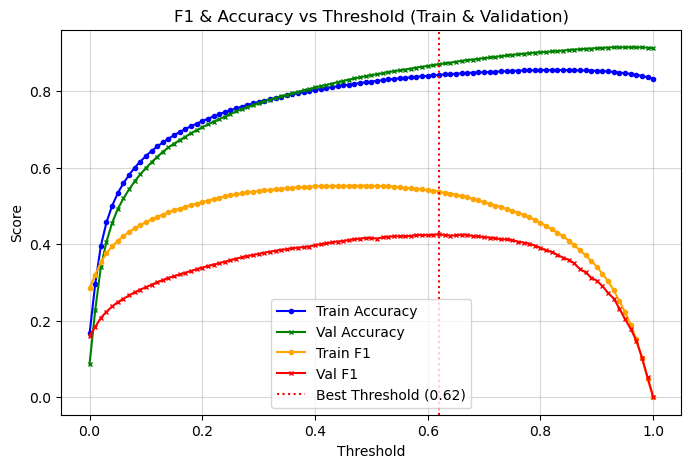

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\3999435135.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


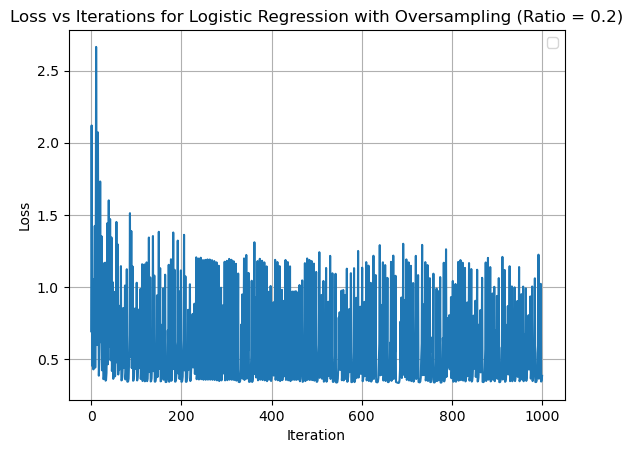

In [34]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
weights_4, losses_4 =logistic_regression(y_over, x_over,initial_w, max_iter, 0.8, return_history=True)

best_t = plot_training_validation_performance(x_over, y_over, data_copy['x_val'], data_copy['y_val'], weights_4, losses_4)

plt.plot(losses_4)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression with Oversampling (Ratio = {best_ratio})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.11 | F1_val = 0.426 | Acc_val = 0.869


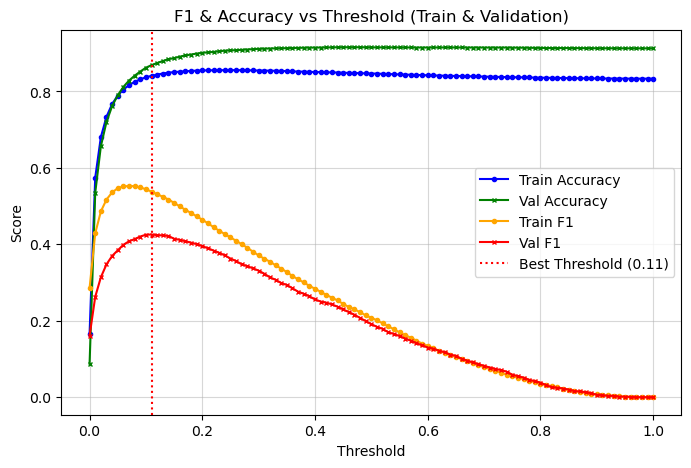

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\206737421.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


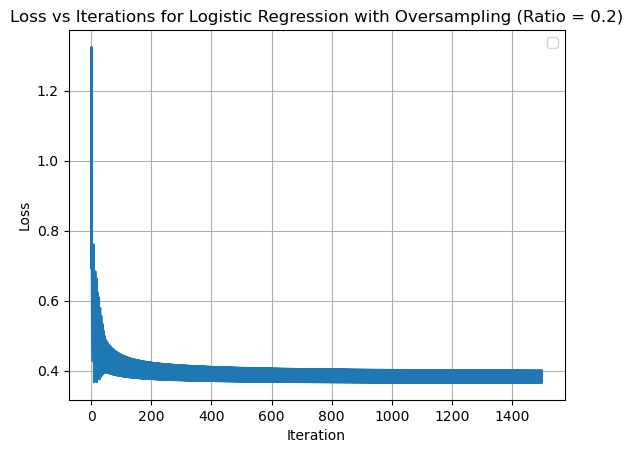

In [ ]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
weights_4, losses_4 =logistic_regression(y_over, x_over,initial_w, max_iter, best_gamma, return_history=True)

best_t = plot_training_validation_performance(x_over, y_over, data_copy['x_val'], data_copy['y_val'], weights_4, losses_4)

plt.plot(losses_4)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression with Oversampling (Ratio = {best_ratio})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.35 | F1_val = 0.424 | Acc_val = 0.876


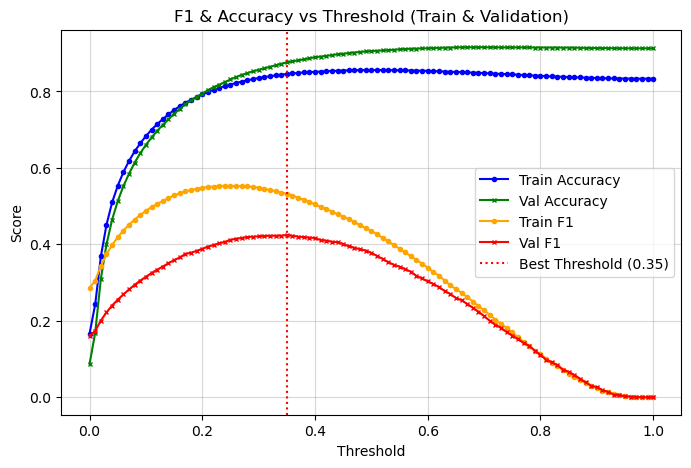

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\2289431232.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


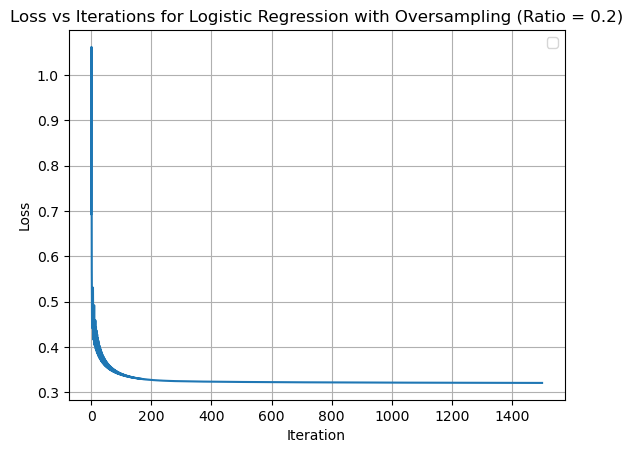

In [18]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
weights_4, losses_4 =logistic_regression(y_over, x_over,initial_w, max_iter, 0.4, return_history=True)

best_t = plot_training_validation_performance(x_over, y_over, data_copy['x_val'], data_copy['y_val'], weights_4, losses_4)

plt.plot(losses_4)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression with Oversampling (Ratio = {best_ratio})")
plt.legend()
plt.grid(True)
plt.show()

✅ Best threshold: 0.33 | F1_val = 0.422 | Acc_val = 0.868


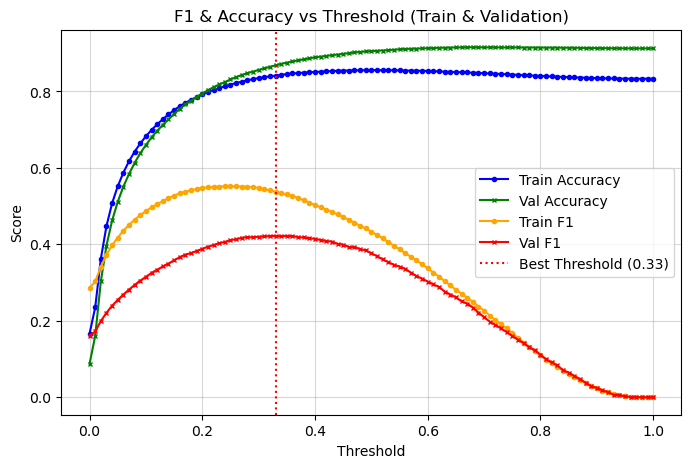

C:\Users\ACER\AppData\Local\Temp\ipykernel_33984\2727212659.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


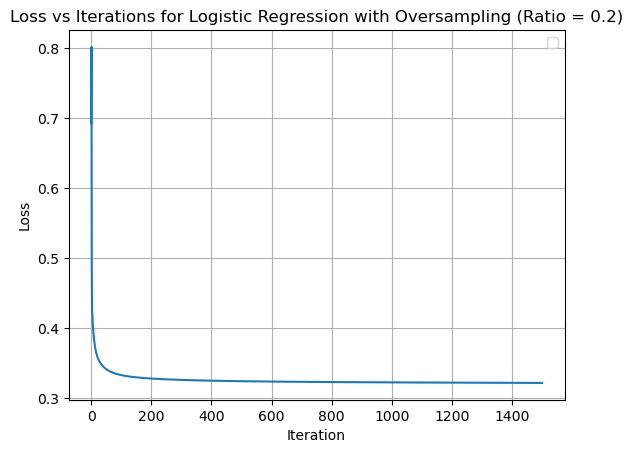

In [19]:
x_over, y_over = oversample_data(data_copy['x_train'], data_copy['y_train'], ratio=best_ratio)
initial_w = np.zeros(x_over.shape[1])
weights_4, losses_4 =logistic_regression(y_over, x_over,initial_w, max_iter, 0.3, return_history=True)

best_t = plot_training_validation_performance(x_over, y_over, data_copy['x_val'], data_copy['y_val'], weights_4, losses_4)

plt.plot(losses_4)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss vs Iterations for Logistic Regression with Oversampling (Ratio = {best_ratio})")
plt.legend()
plt.grid(True)
plt.show()

For the oversampling case, a learning rate of $\gamma = 0.8$ caused oscillations in the training loss, so it was reduced up to 0.3, at which point the loss converged smoothly.

### Final Selection
>Based on cross-validation results, the best performance was achieved with standard logistic regression (no regularization) using a polynomial feature expansion of degree 2 and a learning rate of 0.8.